In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omarrelsayeed","key":"7441b892b8d306faa4a85e097e845293"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d omarrelsayeed/plants-classification

100% 202M/202M [00:11<00:00, 20.9MB/s]
100% 202M/202M [00:11<00:00, 18.6MB/s]


In [ ]:
!unzip /content/plants-classification.zip -d /content/alldataset

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
!pip install timm
from fastkaggle import *
import timm
from fastai.vision.all import *

In [ ]:
comp = 'plant-seedlings-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.69G/1.69G [00:46<00:00, 39.2MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dls = DataBlock((ImageBlock,CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=RandomSplitter(valid_pct=0.40),
                item_tfms=Resize((124 , 124) , method = "squish"),
                batch_tfms = [*aug_transforms(
                   size=(124 , 124),
                   max_rotate = 360,
                   flip_vert = True, 
                   min_scale = 0.75, 
                   max_warp=0   )]).dataloaders("/content/alldataset")

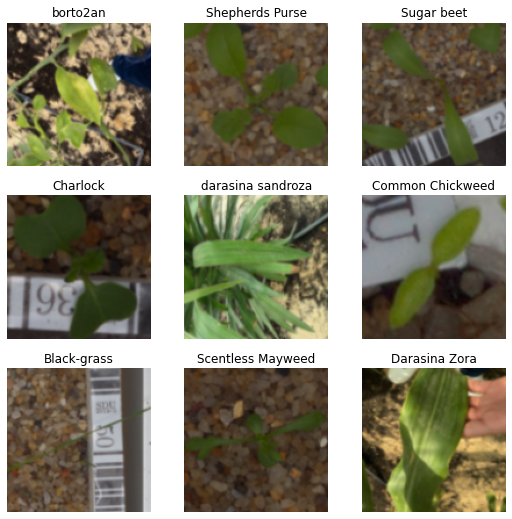

In [ ]:
dls.show_batch()

In [ ]:
# get list of models that start with se
efficient_nets = [model for model in timm.list_models(pretrained=True) if model.startswith('swin')]
efficient_nets

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_s3_base_224',
 'swin_s3_small_224',
 'swin_s3_tiny_224',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224',
 'swinv2_base_window8_256',
 'swinv2_base_window12_192_22k',
 'swinv2_base_window12to16_192to256_22kft1k',
 'swinv2_base_window12to24_192to384_22kft1k',
 'swinv2_base_window16_256',
 'swinv2_cr_small_224',
 'swinv2_cr_small_ns_224',
 'swinv2_cr_tiny_ns_224',
 'swinv2_large_window12_192_22k',
 'swinv2_large_window12to16_192to256_22kft1k',
 'swinv2_large_window12to24_192to384_22kft1k',
 'swinv2_small_window8_256',
 'swinv2_small_window16_256',
 'swinv2_tiny_window8_256',
 'swinv2_tiny_window16_256']

In [ ]:
learn = vision_learner( dls , "convnext_tiny" , metrics=accuracy , path='.' ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


SuggestedLRs(minimum=0.00831763744354248, steep=0.001737800776027143, valley=0.0012022644514217973, slide=2.2908675418875646e-06)

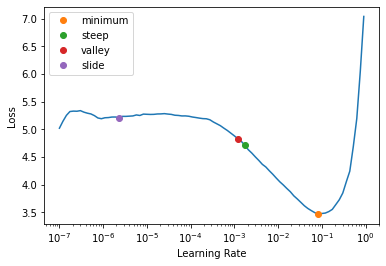

In [ ]:
learn.lr_find( suggest_funcs=( minimum , steep , valley, slide ) )

In [ ]:
learn.fine_tune( 10 , 0.001 )

epoch,train_loss,valid_loss,accuracy,time
0,2.703748,1.086004,0.667454,00:28


epoch,train_loss,valid_loss,accuracy,time
0,1.404792,0.876483,0.729474,00:28
1,1.151989,0.675864,0.781453,00:28
2,0.944288,0.521075,0.828411,00:30
3,0.751545,0.436328,0.855286,00:28
4,0.613793,0.368164,0.879209,00:27
5,0.504490,0.331910,0.888068,00:29
6,0.453091,0.309098,0.898110,00:28
7,0.417583,0.294083,0.904903,00:30
8,0.372009,0.286928,0.902835,00:29
9,0.359630,0.284345,0.905789,00:28


In [ ]:
learn.fine_tune( 5 , 0.001 )

epoch,train_loss,valid_loss,accuracy,time
0,0.143829,0.183596,0.943296,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.152548,0.168991,0.950975,00:30
1,0.157301,0.164822,0.950384,00:29
2,0.129506,0.162535,0.947431,00:31
3,0.120181,0.150393,0.952747,00:28
4,0.114526,0.149903,0.953633,00:28


In [ ]:
learn.export("/content/drive/MyDrive/working_models_new/convnext_tiny_small_size_all_dataset.pkl")

In [ ]:
ss = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")
tst_files = get_image_files("/content/plant-seedlings-classification/test").sorted()
tst_dl = dls.test_dl(tst_files)
probs , _ , idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
ss['label'] = results
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm.csv', index=False)
!head subm.csv

file,species
0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Common Chickweed
00c47e980.png,Sugar beet
00d090cde.png,Black-grass
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent


In [ ]:
#TTA

tst_dl = dls.test_dl(tst_files)
tta_preds , _ = learn.tta(dl=tst_dl)
r = pd.Series(tta_preds.argmax(axis=1).numpy(), name="idxs").map(mapping)
ss['label'] = r
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm2.csv', index=False)
!head subm2.csv

file,species
0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Common Chickweed
00c47e980.png,Sugar beet
00d090cde.png,Loose Silky-bent
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent


In [ ]:
def convert_model_to_pkl(weights_path , arch_name):
  learn = vision_learner( dls , arch_name , metrics=accuracy , path='.'   ).to_fp16()
  learn.load(weights_path)
  learn.export( "/content/drive/MyDrive/working_models/" + arch_name)
convert_model_to_pkl("/content/drive/MyDrive/agr_models/convnext_tiny" , "convnext_tiny")

In [ ]:
ss = pd.read_csv("/content/plant-seedlings-classification/sample_submission.csv")
tst_files = get_image_files("/content/plant-seedlings-classification/test").sorted()
tst_dl = dls.test_dl(tst_files).to("cuda")

def load_and_predict(model_path , tst_dl ):

  m = load_learner(model_path , cpu = False)
  probs , _ , idxs = m.get_preds( dl=tst_dl, with_decoded=True)
  tta_preds , _ = m.tta(dl=tst_dl)
  mapping = dict(enumerate(dls.vocab))
  tta_preds = pd.Series(tta_preds.argmax(axis=1).numpy(), name="idxs").map(mapping)
  results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
  del m , probs , idxs , _
  torch.cuda.empty_cache()
  return results , tta_preds
results , _ = load_and_predict("/content/drive/MyDrive/working_models/convnext_tiny" , tst_dl)

In [ ]:
ss['label'] = results
ss.drop('species' , inplace = True , axis=1)
ss.rename({"label" : "species"} , axis=1 , inplace = True)
ss.to_csv('subm.csv', index=False)
!head subm.csv

file,species
0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Maize
00c47e980.png,Sugar beet
00d090cde.png,Loose Silky-bent
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent


In [ ]:
learn.export("/content/drive/MyDrive/working_models/convnext_tiny_final_96.7985")

In [ ]:
learn.predict("/content/89259b72-e894-465e-b61a-83e3bd044f4e.jpg")

('3asfor',
 TensorBase(0),
 TensorBase([9.9999e-01, 2.1387e-10, 2.6721e-10, 1.0195e-08, 7.5184e-08,
             4.6253e-11, 4.8009e-10, 2.8117e-09, 6.1552e-07, 1.8812e-06,
             6.1046e-10, 4.6706e-08, 1.6479e-08, 6.6935e-08, 6.3259e-07,
             5.4092e-09, 1.5558e-09, 3.1746e-07, 3.7657e-08, 5.2625e-10,
             2.2542e-11, 7.1370e-10, 5.6238e-10, 1.0026e-09, 1.3892e-09,
             1.6391e-08, 1.0389e-06, 1.3394e-08, 3.3728e-07, 3.7705e-06,
             3.0511e-08, 1.6567e-07, 2.3265e-09, 2.2770e-09]))